In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import time
from os import cpu_count
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error

import pandas_profiling as pp

import lightgbm as lgb

In [106]:
import matplotlib.style as stl
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pylab
plt.rcParams['figure.figsize'] = 16, 10
%matplotlib inline

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
n_jobs = max(cpu_count()-1, 1)

In [3]:
train = pd.read_csv("D:/Job/interview/datascientist-master/train_ds.csv")
test = pd.read_csv("D:/Job/interview/datascientist-master/test_ds.csv")

# Exploring data

In [4]:
train.head()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid
0,1,4131,978,980,6730,TRAMBESOS SANT JOAN DES ES,1385977762,1,13
1,2,5651,978,980,55912,ZARA BARCELONA P GRACIABARCELONA ES,1385991764,1,13
2,3,5812,978,980,135658,CAFE DE L'ACADEMIA BARCELONA ES,1385999148,1,13
3,4,5947,978,980,138294,2D BCN DISSENY EN BIJUTBARCELONA ES,1385999979,1,13
4,5,5651,978,980,426209,EL GANSO BARCELONA ES,1386005648,1,13


In [5]:
test.head()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,clientid
0,395,5411,980,980,7488,VOPAK 7301 UZHGOROD UA,1393172737,712
1,422,6010,980,980,40000,ODESA REGIONAL DEP. ODESSA UA,1393509649,766
2,429,6010,980,980,119000,ODESA REGIONAL DEP. ODESSA UA,1393583520,745
3,435,6010,980,980,210000,ODESA REGIONAL DEP. ODESSA UA,1393591808,748
4,445,6011,980,980,30000,"GAGARINA, 13 ODESSA UA",1393766754,766


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92700 entries, 0 to 92699
Data columns (total 9 columns):
cgsettlementbufferid    92700 non-null int64
mcc                     92700 non-null int64
tranccy                 92700 non-null int64
ccy                     92700 non-null int64
amount                  92700 non-null int64
location                92700 non-null object
trandatetime            92700 non-null int64
sexid                   92700 non-null int64
clientid                92700 non-null int64
dtypes: int64(8), object(1)
memory usage: 6.4+ MB


In [9]:
profile_train = pp.ProfileReport(train)
profile_train.to_file(outputfile="profile_train.html")

In [10]:
profile_test = pp.ProfileReport(test)
profile_test.to_file(outputfile="profile_test.html")

# Preprocessing data

In [11]:
train_location = train.location
test_location = test.location

In [12]:
train_location.head()

0    TRAMBESOS              SANT JOAN DES  ES
1    ZARA BARCELONA P GRACIABARCELONA      ES
2    CAFE DE L'ACADEMIA     BARCELONA      ES
3    2D BCN DISSENY EN BIJUTBARCELONA      ES
4    EL GANSO               BARCELONA      ES
Name: location, dtype: object

In [13]:
test_location.head()

0    VOPAK 7301             UZHGOROD       UA
1    ODESA REGIONAL DEP.    ODESSA         UA
2    ODESA REGIONAL DEP.    ODESSA         UA
3    ODESA REGIONAL DEP.    ODESSA         UA
4    GAGARINA, 13           ODESSA         UA
Name: location, dtype: object

In [14]:
test_df = test.copy() 
train_df = train.copy()

In [15]:
institution_transaction_train = list()
city_transaction_train  = list()
country_transaction_train  = list()
institution_transaction_test = list()
city_transaction_test = list()
country_transaction_test = list()

In [16]:
for i in range(0,train_location.size):
    institution_transaction_train.append(train_location[i][0:23])
    city_transaction_train.append(train_location[i][23:38])
    country_transaction_train.append(train_location[i][38:])

In [17]:
for i in range(0,test_location.size):
    institution_transaction_test.append(test_location[i][0:23])
    city_transaction_test.append(test_location[i][23:38])
    country_transaction_test.append(test_location[i][38:])

In [18]:
del_tabs = lambda x: re.sub(r"\s+", " ", x).rstrip('\t\n ')

In [19]:
institution_transaction_train = pd.DataFrame(institution_transaction_train)[0].apply(del_tabs)
city_transaction_train = pd.DataFrame(city_transaction_train)[0].apply(del_tabs)
country_transaction_train = pd.DataFrame(country_transaction_train)[0].apply(del_tabs)

institution_transaction_test = pd.DataFrame(institution_transaction_test)[0].apply(del_tabs)
city_transaction_test = pd.DataFrame(city_transaction_test)[0].apply(del_tabs)
country_transaction_test = pd.DataFrame(country_transaction_test)[0].apply(del_tabs)

In [20]:
train_df["institution_transaction"] = institution_transaction_train
train_df["city_transaction"] = city_transaction_train
train_df["country_transaction"] = country_transaction_train

In [21]:
test_df["institution_transaction"] = institution_transaction_test
test_df["city_transaction"] = city_transaction_test
test_df["country_transaction"] = country_transaction_test

In [22]:
train_df.head()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
0,1,4131,978,980,6730,TRAMBESOS SANT JOAN DES ES,1385977762,1,13,TRAMBESOS,SANT JOAN DES,ES
1,2,5651,978,980,55912,ZARA BARCELONA P GRACIABARCELONA ES,1385991764,1,13,ZARA BARCELONA P GRACIA,BARCELONA,ES
2,3,5812,978,980,135658,CAFE DE L'ACADEMIA BARCELONA ES,1385999148,1,13,CAFE DE L'ACADEMIA,BARCELONA,ES
3,4,5947,978,980,138294,2D BCN DISSENY EN BIJUTBARCELONA ES,1385999979,1,13,2D BCN DISSENY EN BIJUT,BARCELONA,ES
4,5,5651,978,980,426209,EL GANSO BARCELONA ES,1386005648,1,13,EL GANSO,BARCELONA,ES


In [23]:
train_df.tail()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
92695,147546,5499,980,980,12870,PR305 ZAPOROZHYE UAUA,1437413456,1,9378,PR305,ZAPOROZHYE UA,UA
92696,147547,5499,980,980,11529,2SHAGAJUKOVA ODESSA UAUA,1437413573,0,3533,2SHAGAJUKOVA,ODESSA UA,UA
92697,147550,5499,980,980,2379,B09 LVOV UAUA,1437413997,1,7745,B09,LVOV UA,UA
92698,147554,5499,980,980,4650,magazin1189 Brovari UAUA,1437414625,1,7287,magazin1189,Brovari UA,UA
92699,147555,5541,980,980,50017,PREMIERLIGA26 KIYEV UAUA,1437414806,0,9001,PREMIERLIGA26,KIYEV UA,UA


In [24]:
test_df.head()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,clientid,institution_transaction,city_transaction,country_transaction
0,395,5411,980,980,7488,VOPAK 7301 UZHGOROD UA,1393172737,712,VOPAK 7301,UZHGOROD,UA
1,422,6010,980,980,40000,ODESA REGIONAL DEP. ODESSA UA,1393509649,766,ODESA REGIONAL DEP.,ODESSA,UA
2,429,6010,980,980,119000,ODESA REGIONAL DEP. ODESSA UA,1393583520,745,ODESA REGIONAL DEP.,ODESSA,UA
3,435,6010,980,980,210000,ODESA REGIONAL DEP. ODESSA UA,1393591808,748,ODESA REGIONAL DEP.,ODESSA,UA
4,445,6011,980,980,30000,"GAGARINA, 13 ODESSA UA",1393766754,766,"GAGARINA, 13",ODESSA,UA


In [25]:
test_df.tail()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,clientid,institution_transaction,city_transaction,country_transaction
40554,147548,5499,980,980,21185,PR305 ZAPOROZHYE UAUA,1437413578,9382,PR305,ZAPOROZHYE UA,UA
40555,147549,5411,980,980,49453,TMETRO16 KIYEV UAUA,1437413600,2136,TMETRO16,KIYEV UA,UA
40556,147551,6538,980,980,300000,MFPay2youAC Kiiev UAUA,1437414144,7145,MFPay2youAC,Kiiev UA,UA
40557,147552,5977,980,980,31400,LUSH ODESSA ODESSA UAUA,1437414216,1076,LUSH ODESSA,ODESSA UA,UA
40558,147553,5499,980,980,2257,OD019 ODESSA UAUA,1437414269,1582,OD019,ODESSA UA,UA


In [26]:
profile_train_2 = pp.ProfileReport(train_df)
profile_train_2.to_file(outputfile="profile_train_2.html")

In [27]:
profile_test_2 = pp.ProfileReport(test_df)
profile_test_2.to_file(outputfile="profile_test_2.html")

In [35]:
train_df.loc[train_df.duplicated(keep=False),:]

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
1700,2367,5812,643,980,266325,RESTAURANT KAFE PUSHKINMOSKVA RU,1397923546,1,878,RESTAURANT KAFE PUSHKIN,MOSKVA,RU
1701,2367,5812,643,980,266325,RESTAURANT KAFE PUSHKINMOSKVA RU,1397923546,1,878,RESTAURANT KAFE PUSHKIN,MOSKVA,RU
3001,3988,4722,826,980,414557,THETRAVELGATEWAY FERRY & TRAVE GB,1400007925,1,552,THETRAVELGATEWAY,FERRY & TRAVE,GB
3002,3988,4722,826,980,414557,THETRAVELGATEWAY FERRY & TRAVE GB,1400007925,1,552,THETRAVELGATEWAY,FERRY & TRAVE,GB
4899,8114,7011,978,980,748707,HOTEL MARINEDDA PALAU IT,1403607263,1,2401,HOTEL MARINEDDA,PALAU,IT
4900,8114,7011,978,980,748707,HOTEL MARINEDDA PALAU IT,1403607263,1,2401,HOTEL MARINEDDA,PALAU,IT
5131,8508,5812,978,980,113598,COCCODRILLUS TRINITA' D'AG IT,1403788504,1,2401,COCCODRILLUS,TRINITA' D'AG,IT
5132,8508,5812,978,980,113598,COCCODRILLUS TRINITA' D'AG IT,1403788504,1,2401,COCCODRILLUS,TRINITA' D'AG,IT
5228,7150,3807,840,980,211559,ELEMENT LAS VEGAS LAS VEGAS NVUS,1402746865,1,1577,ELEMENT LAS VEGAS,LAS VEGAS NV,US
5229,7150,3807,840,980,211559,ELEMENT LAS VEGAS LAS VEGAS NVUS,1402746865,1,1577,ELEMENT LAS VEGAS,LAS VEGAS NV,US


In [32]:
train_df.duplicated().sum()

134

In [37]:
train_df.shape

(92700, 12)

In [40]:
train_df = train_df.drop_duplicates(keep="first")

In [41]:
train_df.shape

(92566, 12)

In [42]:
train_df.duplicated().sum()

0

# Task A

In [43]:
train_df_A = train_df.copy()
test_df_A = test_df.copy()

In [44]:
#train_df_A.drop(["location","city_transaction","country_transaction"],axis=1,inplace=True)
#test_df_A.drop(["location","city_transaction","country_transaction"],axis=1,inplace=True)
train_df_A.drop(["location"],axis=1,inplace=True)
test_df_A.drop(["location"],axis=1,inplace=True)

In [45]:
train_df_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92566 entries, 0 to 92699
Data columns (total 11 columns):
cgsettlementbufferid       92566 non-null int64
mcc                        92566 non-null int64
tranccy                    92566 non-null int64
ccy                        92566 non-null int64
amount                     92566 non-null int64
trandatetime               92566 non-null int64
sexid                      92566 non-null int64
clientid                   92566 non-null int64
institution_transaction    92566 non-null object
city_transaction           92566 non-null object
country_transaction        92566 non-null object
dtypes: int64(8), object(3)
memory usage: 8.5+ MB


In [46]:
test_df_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40559 entries, 0 to 40558
Data columns (total 10 columns):
cgsettlementbufferid       40559 non-null int64
mcc                        40559 non-null int64
tranccy                    40559 non-null int64
ccy                        40559 non-null int64
amount                     40559 non-null int64
trandatetime               40559 non-null int64
clientid                   40559 non-null int64
institution_transaction    40559 non-null object
city_transaction           40559 non-null object
country_transaction        40559 non-null object
dtypes: int64(7), object(3)
memory usage: 3.1+ MB


#to_timespan = (lambda x: time.mktime(x.timetuple()))

In [47]:
categorical = [
    'institution_transaction',
    'city_transaction',
    'country_transaction'
]

In [48]:
#from collections import defaultdict
#from sklearn.preprocessing import LabelEncoder

def __encode_categorical(df_list, cat_cols):
    # initialize placeholder
    d = defaultdict(LabelEncoder)
    # fit and encode train/test,
    codes = pd.concat(
        [df[cat_cols] for df in df_list],
        axis=0
    ).fillna('').apply(
        lambda x: d[x.name].fit(x)
    ),
    # transform encodings to train/test etc
    for df in df_list:
        df[cat_cols] = df[cat_cols].fillna('').apply(
            lambda x: d[x.name].transform(x))

__encode_categorical(df_list=[train_df_A, test_df_A], cat_cols=categorical) 

In [49]:
train_df_A.head()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
0,1,4131,978,980,6730,1385977762,1,13,20316,2754,30
1,2,5651,978,980,55912,1385991764,1,13,22254,422,30
2,3,5812,978,980,135658,1385999148,1,13,5443,422,30
3,4,5947,978,980,138294,1385999979,1,13,653,422,30
4,5,5651,978,980,426209,1386005648,1,13,8015,422,30


In [50]:
test_df_A.head()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,trandatetime,clientid,institution_transaction,city_transaction,country_transaction
0,395,5411,980,980,7488,1393172737,712,21650,3198,87
1,422,6010,980,980,40000,1393509649,766,14491,2247,87
2,429,6010,980,980,119000,1393583520,745,14491,2247,87
3,435,6010,980,980,210000,1393591808,748,14491,2247,87
4,445,6011,980,980,30000,1393766754,766,9353,2247,87


# Validation

In [136]:
X = train_df_A.drop(['sexid'], axis=1)
y = train_df_A['sexid']

In [137]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [145]:
parameters={
   'objective': 'binary',
    'learning_rate': 0.01,
    'max_depth': 8,
    'num_threads': 4,
    'metric': 'mae',
    'seed': 42,
    'colsample_bytree': 0.9,
    'subsample': 0.9,
    'subsample_freq': 2,
    'min_data_in_leaf': 15,
}
n_rounds = 50000

In [139]:
(100/(train_df_A.shape[0]+test_df_A.shape[0]))*40559

30.4668544600939

In [140]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.304, random_state=42)

In [141]:
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)

In [142]:
lgb_val =  lgb.Dataset(X_val, label=y_val, free_raw_data=False)

In [143]:
evals_result = {} 

In [146]:
lgd_classifier = lgb.cv(parameters, lgb_train, n_rounds, folds=skf.split(X_train, y_train), early_stopping_rounds=10, verbose_eval=1000, )

[1000]	cv_agg's l1: 0.274132 + 0.00124627
[2000]	cv_agg's l1: 0.223878 + 0.00160019
[3000]	cv_agg's l1: 0.196814 + 0.00144577
[4000]	cv_agg's l1: 0.179401 + 0.00173119
[5000]	cv_agg's l1: 0.166616 + 0.00158843
[6000]	cv_agg's l1: 0.156474 + 0.00139564
[7000]	cv_agg's l1: 0.148387 + 0.00149364
[8000]	cv_agg's l1: 0.141432 + 0.00128273
[9000]	cv_agg's l1: 0.135621 + 0.00141758
[10000]	cv_agg's l1: 0.130533 + 0.00126907
[11000]	cv_agg's l1: 0.126126 + 0.00128298
[12000]	cv_agg's l1: 0.122304 + 0.00134171
[13000]	cv_agg's l1: 0.118765 + 0.00133354
[14000]	cv_agg's l1: 0.115597 + 0.00128614
[15000]	cv_agg's l1: 0.112799 + 0.00132497
[16000]	cv_agg's l1: 0.110115 + 0.00130807
[17000]	cv_agg's l1: 0.107741 + 0.00132607
[18000]	cv_agg's l1: 0.10559 + 0.00133004
[19000]	cv_agg's l1: 0.103598 + 0.00130361
[20000]	cv_agg's l1: 0.101789 + 0.00131713
[21000]	cv_agg's l1: 0.100058 + 0.00123268
[22000]	cv_agg's l1: 0.0984228 + 0.00121372
[23000]	cv_agg's l1: 0.0969747 + 0.00121421
[24000]	cv_agg's l1

In [147]:
print(min(lgd_classifier['l1-mean']), len(lgd_classifier['l1-mean']))

0.08623147778151015 34204


In [168]:
n_rounds=50000

In [169]:
bst = lgb.train(parameters, lgb_train, n_rounds, valid_sets=[lgb_train, lgb_val], evals_result=evals_result, verbose_eval=1000, early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds.
[1000]	training's l1: 0.267852	valid_1's l1: 0.2723
[2000]	training's l1: 0.213389	valid_1's l1: 0.221344
[3000]	training's l1: 0.183634	valid_1's l1: 0.194724
[4000]	training's l1: 0.162566	valid_1's l1: 0.176606
[5000]	training's l1: 0.147217	valid_1's l1: 0.164029
[6000]	training's l1: 0.134212	valid_1's l1: 0.153603
[7000]	training's l1: 0.123667	valid_1's l1: 0.145391
[8000]	training's l1: 0.114811	valid_1's l1: 0.138819
[9000]	training's l1: 0.106578	valid_1's l1: 0.132747
[10000]	training's l1: 0.0996025	valid_1's l1: 0.127864
[11000]	training's l1: 0.0931033	valid_1's l1: 0.123194
[12000]	training's l1: 0.0874739	valid_1's l1: 0.119312
[13000]	training's l1: 0.0821982	valid_1's l1: 0.115765
[14000]	training's l1: 0.077398	valid_1's l1: 0.112545
[15000]	training's l1: 0.072996	valid_1's l1: 0.109654
[16000]	training's l1: 0.0688853	valid_1's l1: 0.107
[17000]	training's l1: 0.0651086	valid_1's l1: 0.104617
[18000]	tra

Plot metrics during training...


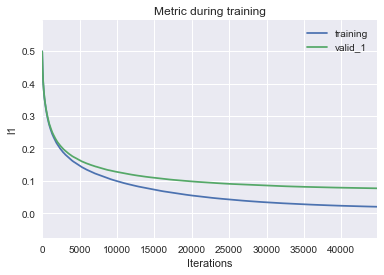

In [170]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

Plot feature importances...


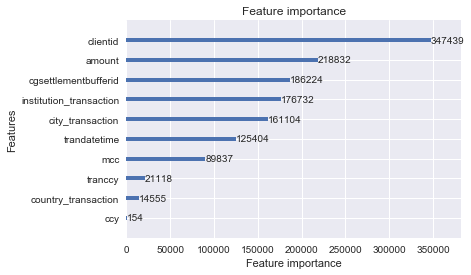

In [171]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=10)
plt.show()

In [172]:
predict_lgb = bst.predict(X_val,num_iteration=bst.best_iteration)

In [173]:
mean_absolute_error(y_val,predict_lgb)

0.07734693294131992

In [174]:
bst.best_iteration

44715

In [175]:
bst.best_score

defaultdict(dict,
            {'training': {'l1': 0.02066844992994975},
             'valid_1': {'l1': 0.07734693294131999}})

# Prediction

In [183]:
X_train = train_df_A.drop("sexid",axis=1)
y_train = train_df_A["sexid"]

In [184]:
lgb_dataset = lgb.Dataset(X_train, label=y_train, free_raw_data=False)

In [185]:
n_rounds = 44715

In [186]:
bst_classifier = lgb.train(parameters, lgb_train, n_rounds)

In [189]:
test_df_A = test_df_A.sort_values(by='clientid')

In [196]:
predict = bst_classifier.predict(test_df_A,num_iteration=n_rounds)

In [197]:
predict

array([0.88959085, 0.49910147, 0.10789952, ..., 0.97258553, 0.98101085,
       0.99999443])

In [199]:
test_df_A["PREDICTION"] = predict

In [200]:
predict_mean = test_df_A.groupby("clientid")["PREDICTION"].mean()

# Submition

In [202]:
predict_mean = predict_mean.reset_index()

In [212]:
submition = pd.DataFrame({'clientid': predict_mean.clientid})
submition['sexid'] = predict_mean.PREDICTION
submition.to_csv('output_draft.csv', index=False)

In [213]:
submition.head()

,clientid,sexid
0,521,0.457020
1,537,0.894860
2,541,0.676534
3,553,0.775366
4,570,0.899579


In [214]:
submition.tail()

,clientid,sexid
991,10409,0.692175
992,10799,0.877653
993,11281,0.998046
994,11332,0.986127
995,11602,0.990503


In [215]:
result = pd.read_csv("output_draft.csv")

In [216]:
result.head()

,clientid,sexid
0,521,0.457020
1,537,0.894860
2,541,0.676534
3,553,0.775366
4,570,0.899579


In [217]:
result.tail()

,clientid,sexid
991,10409,0.692175
992,10799,0.877653
993,11281,0.998046
994,11332,0.986127
995,11602,0.990503


# Task B 

### Предлагаем вам поиграть в детектива. Все имеющиеся у нас данные вы найдёте в train_ds.csv.

### Мы знаем, что Джон Доу прилетел в Украину в начале июля 2015-го. Также известно, что 6го июля Джон ужинал в явочном кафе в Киеве и передал секретные документы другому шпиону, но в толпе наш агент его потерял.

### Отыщите место проживания Джона Доу.

In [218]:
from_timespan = (lambda x: datetime.datetime.fromtimestamp(x))

In [222]:
# from timespan to datetime
train_df["trandatetime"] = train_df["trandatetime"].apply(from_timespan)

In [223]:
train_df.head()

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
0,1,4131,978,980,6730,TRAMBESOS SANT JOAN DES ES,2013-12-02 11:49:22,1,13,TRAMBESOS,SANT JOAN DES,ES
1,2,5651,978,980,55912,ZARA BARCELONA P GRACIABARCELONA ES,2013-12-02 15:42:44,1,13,ZARA BARCELONA P GRACIA,BARCELONA,ES
2,3,5812,978,980,135658,CAFE DE L'ACADEMIA BARCELONA ES,2013-12-02 17:45:48,1,13,CAFE DE L'ACADEMIA,BARCELONA,ES
3,4,5947,978,980,138294,2D BCN DISSENY EN BIJUTBARCELONA ES,2013-12-02 17:59:39,1,13,2D BCN DISSENY EN BIJUT,BARCELONA,ES
4,5,5651,978,980,426209,EL GANSO BARCELONA ES,2013-12-02 19:34:08,1,13,EL GANSO,BARCELONA,ES


In [224]:
cities = ['KIEV','KYIV','KIYEV','KYIV UA','KIYEV UA','KIEV UA']

In [225]:
# find all raws where dataetime between 2015-06-06 18:00:00 and 2015-06-07/ and city Kyiv
j_d = train_df[((train_df['trandatetime']>=pd.to_datetime("2015-06-06 18:00:00"))&
                (train_df['trandatetime']<pd.to_datetime("2015-06-07"))) 
               &
               ((train_df['city_transaction']==cities[0])|(train_df['city_transaction']==cities[1])|
                (train_df['city_transaction']==cities[2])|(train_df['city_transaction']==cities[3])|
                (train_df['city_transaction']==cities[4])|(train_df['city_transaction']==cities[5]))]

In [226]:
# get unique client id's
unique_id = j_d.clientid.unique()

In [227]:
unique_id

array([4731, 2166, 7705, 6535, 3523, 5744, 1133, 6584, 3753, 5749, 6197,
       5012, 5800, 4009, 1282, 2401, 8327, 9239, 6474, 4749, 3094, 3441,
       8824,  722, 5603, 8599, 2386,  724, 2391,  881, 2516, 8457, 6780],
      dtype=int64)

In [228]:
unique_id.size

33

In [ ]:
# find clients that wasn't in Ukrain before 2015-06-01 

In [229]:
train_df[(train_df["clientid"]==unique_id[2])&
         (train_df['trandatetime']<pd.to_datetime("2015-06-01"))&
         (train_df["country_transaction"] =="UA")].sort_values(by='trandatetime')

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction


In [230]:
train_df[(train_df["clientid"]==unique_id[17])&
         (train_df['trandatetime']<pd.to_datetime("2015-06-01"))&
         (train_df["country_transaction"] =="UA")].sort_values(by='trandatetime')

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction


In [231]:
train_df[train_df['clientid']==unique_id[2]].sort_values(by='trandatetime')

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
74895,119622,6536,980,980,13800,MPPay2youAC KYIV UA,2015-06-04 17:04:45,1,7705,MPPay2youAC,KYIV,UA
75764,121236,6012,980,980,500,MY.ALFABANK.UA KIEV UAUA,2015-06-05 04:19:01,1,7705,MY.ALFABANK.UA,KIEV UA,UA
75765,121237,6012,980,980,100,MY.ALFABANK.UA KIEV UAUA,2015-06-05 04:29:20,1,7705,MY.ALFABANK.UA,KIEV UA,UA
75783,121265,6538,980,980,13201,TS000000 NOVOVOLYNSK UAUA,2015-06-05 11:31:00,1,7705,TS000000,NOVOVOLYNSK UA,UA
75850,121211,5541,980,980,29992,AZSVladimirskaya LUTSK UAUA,2015-06-05 12:41:37,1,7705,AZSVladimirskaya,LUTSK UA,UA
75851,121212,5541,980,980,7200,AZSVladimirskaya LUTSK UAUA,2015-06-05 12:42:17,1,7705,AZSVladimirskaya,LUTSK UA,UA
75916,121316,5499,980,980,12000,ProduktyVOY0 LUTSK UAUA,2015-06-05 12:49:38,1,7705,ProduktyVOY0,LUTSK UA,UA
75911,121311,5541,980,980,72000,AZS WOG SOBORNOSTI LUTSK UAUA,2015-06-05 16:14:27,1,7705,AZS WOG SOBORNOSTI,LUTSK UA,UA
75972,121397,5541,980,980,1800,AZSVladimirskaya LUTSK UAUA,2015-06-05 17:18:54,1,7705,AZSVladimirskaya,LUTSK UA,UA
75973,121398,5541,980,980,24000,AZS WOG 16 WOLYA V OMELYANYK UAUA,2015-06-05 17:22:21,1,7705,AZS WOG 16 WOLYA,V OMELYANYK UA,UA


In [233]:
train_df[train_df['clientid']==unique_id[17]].sort_values(by='trandatetime')

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
75902,121301,7399,980,980,36802,SYTO-PIANO KYIV UAUA,2015-06-04 15:32:00,1,9239,SYTO-PIANO,KYIV UA,UA
76033,121561,5499,980,980,7670,EKOPOZ KIYEV UAUA,2015-06-06 13:18:17,1,9239,EKOPOZ,KIYEV UA,UA
76050,121815,5812,980,980,168210,PANAROMARESTAURANT KIYEV UAUA,2015-06-06 21:47:37,1,9239,PANAROMARESTAURANT,KIYEV UA,UA
76577,122618,5541,980,980,175212,SOCAR PETROL STATIONS KYIV UAUA,2015-06-07 12:47:42,1,9239,SOCAR PETROL STATIONS,KYIV UA,UA
79427,127575,5812,980,980,36900,DUKHMYANA PICH LESINKI UA,2015-06-15 15:54:23,1,9239,DUKHMYANA PICH,LESINKI,UA
81441,130454,5812,980,980,93400,ALMERIJA PLAZA GULLIVE KYIV UAUA,2015-06-20 01:58:13,1,9239,ALMERIJA PLAZA GULLIVE,KYIV UA,UA
81483,130758,5812,980,980,25000,DaliPark KIYEV UAUA,2015-06-21 01:49:16,1,9239,DaliPark,KIYEV UA,UA
86475,138318,5812,980,980,41802,PESTO CAFE KYIV UAUA,2015-07-02 22:25:42,1,9239,PESTO CAFE,KYIV UA,UA
87679,140332,5921,980,980,80464,WINE TIME KYIV UAUA,2015-07-07 20:17:59,1,9239,WINE TIME,KYIV UA,UA
89651,143103,5812,980,980,48800,HASTRO KAFE TARELKA KYIV UAUA,2015-07-10 15:40:27,1,9239,HASTRO KAFE TARELKA,KYIV UA,UA


In [ ]:
# Client with id 7705 have no transactions from restaurants  

# John Dou id 9239 and he lives in Radisson Blu hotel in YAREMCHE UA

In [237]:
john_dou = train_df[train_df['clientid']==unique_id[17]].sort_values(by='trandatetime')

In [249]:
john_dou.iloc[2:3,:] # restaurant

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
76050,121815,5812,980,980,168210,PANAROMARESTAURANT KIYEV UAUA,2015-06-06 21:47:37,1,9239,PANAROMARESTAURANT,KIYEV UA,UA


In [252]:
john_dou.iloc[-2:-1,:] # hotel

,cgsettlementbufferid,mcc,tranccy,ccy,amount,location,trandatetime,sexid,clientid,institution_transaction,city_transaction,country_transaction
91839,146382,7011,980,980,240825,RADISSONBLU YAREMCHE UAUA,2015-07-17 22:07:24,1,9239,RADISSONBLU,YAREMCHE UA,UA
